In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: show plots inside notebook
%matplotlib inline


In [2]:
df = pd.read_xml("data/etrm_trades.xml")

# Preview
print(df.head())


   TradeID Commodity TradeType  Volume   Price Currency DeliveryStart  \
0        1     Power       BUY  193.52  191.13      GBP    2025-01-08   
1        2       Gas       BUY  368.68  127.76      GBP    2025-01-29   
2        3     Power      SELL   86.45   48.08      USD    2025-01-03   
3        4       Gas       BUY   38.46  175.91      GBP    2025-01-23   
4        5      Coal       BUY  304.55  147.45      EUR    2025-01-09   

  DeliveryEnd Periodicity  
0  2025-01-16     Monthly  
1  2025-02-16   Quarterly  
2  2025-01-10       Daily  
3  2025-02-13       Daily  
4  2025-02-04   Quarterly  


In [3]:
# Convert DeliveryStart and DeliveryEnd into datetime (YYYY-MM-DD)
df["DeliveryStart"] = pd.to_datetime(df["DeliveryStart"], errors="coerce")
df["DeliveryEnd"]   = pd.to_datetime(df["DeliveryEnd"], errors="coerce")

# Verify conversion
print(df[["DeliveryStart", "DeliveryEnd"]].head())
# print(df.dtypes)

  DeliveryStart DeliveryEnd
0    2025-01-08  2025-01-16
1    2025-01-29  2025-02-16
2    2025-01-03  2025-01-10
3    2025-01-23  2025-02-13
4    2025-01-09  2025-02-04


In [4]:
# Swap if start > end
mask = (df["DeliveryStart"] > df["DeliveryEnd"])
df.loc[mask, ["DeliveryStart", "DeliveryEnd"]] = df.loc[mask, ["DeliveryEnd", "DeliveryStart"]].values

# Drop rows where both are NaT
df = df.dropna(subset=["DeliveryStart", "DeliveryEnd"], how="all")

In [5]:
print("Missing Volume:", df["Volume"].isna().sum())
print("Missing Price:", df["Price"].isna().sum())

Missing Volume: 0
Missing Price: 0


In [6]:
df = df[(df["Volume"] > 0) & (df["Price"] > 0)]

In [7]:
df["Notional"] = df["Volume"] * df["Price"]

In [8]:
# Top commodities by traded volume
print(df.groupby("Commodity")["Volume"].sum())



Commodity
Coal     4799.25
Gas      7442.02
Oil      5594.38
Power    6735.49
Name: Volume, dtype: float64


In [9]:
# Average price per commodity
print(df.groupby("Commodity")["Price"].mean())

Commodity
Coal     104.642941
Gas      119.778437
Oil      101.757826
Power    100.469643
Name: Price, dtype: float64


In [10]:
# Trades by currency
print(df["Currency"].value_counts())

Currency
GBP    38
USD    34
EUR    28
Name: count, dtype: int64


In [11]:
# Trades by periodicity
print(df["Periodicity"].value_counts())

Periodicity
Daily        41
Quarterly    31
Monthly      28
Name: count, dtype: int64


In [12]:
#top 5 notional value
top5_trades = df.nlargest(5, "Notional")[["TradeID", "Commodity", "TradeType", "Notional"]]
print(top5_trades)

    TradeID Commodity TradeType    Notional
26       27     Power      SELL  85166.2745
91       92      Coal       BUY  82394.7520
17       18       Oil      SELL  79967.8116
25       26       Oil       BUY  77383.1520
56       57       Gas      SELL  77029.9030


In [13]:
#top 5 commodity by total volume
top5_volume = df.groupby("Commodity")["Volume"].sum().sort_values(ascending=False).head(5)
print(top5_volume)


Commodity
Gas      7442.02
Power    6735.49
Oil      5594.38
Coal     4799.25
Name: Volume, dtype: float64


In [14]:
#duration of the deliveries
df["Duration_days"] = (df["DeliveryEnd"] - df["DeliveryStart"]).dt.days
print(df[["TradeID", "Commodity", "Duration_days"]].head())

#average duration
avg_duration = df.groupby("Commodity")["Duration_days"].mean()
print(avg_duration)

   TradeID Commodity  Duration_days
0        1     Power              8
1        2       Gas             18
2        3     Power              7
3        4       Gas             21
4        5      Coal             26
Commodity
Coal     17.117647
Gas      12.156250
Oil      16.826087
Power    16.392857
Name: Duration_days, dtype: float64


    TradeID Commodity  Volume   Price Currency
77       78      Coal  492.97   63.57      EUR
25       26       Oil  485.10  159.52      EUR
17       18       Oil  483.16  165.51      EUR
70       71      Coal  481.60   65.32      USD
67       68       Oil  472.03   78.18      GBP


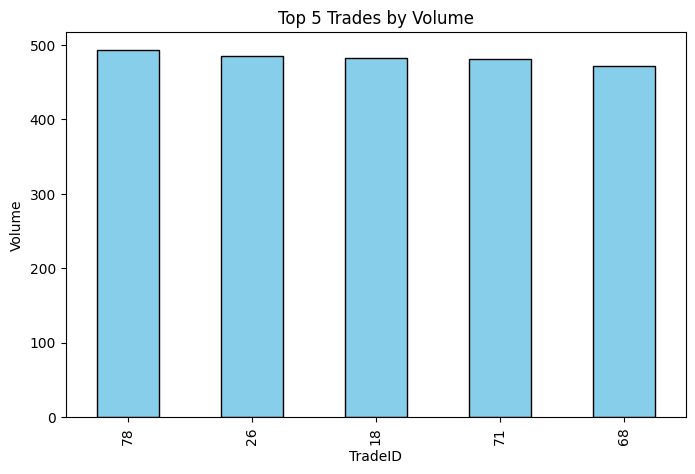

In [15]:
# Top 5 trades by Volume
top5_trades = df.nlargest(5, "Volume")[["TradeID", "Commodity", "Volume", "Price", "Currency"]]
print(top5_trades)

# Plot
top5_trades.set_index("TradeID")["Volume"].plot(
    kind="bar", color="skyblue", edgecolor="black", figsize=(8, 5)
)
plt.title("Top 5 Trades by Volume")
plt.ylabel("Volume")
plt.xlabel("TradeID")
plt.show()


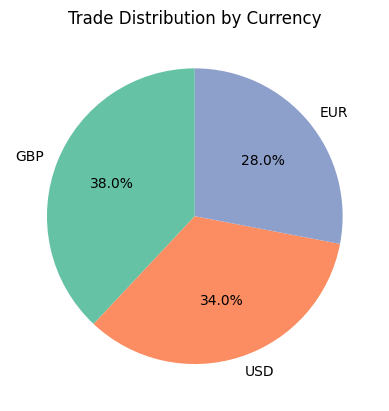

In [16]:
# 2. Pie chart: Trades by Currency
currency_counts = df["Currency"].value_counts()
currency_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90, colors=sns.color_palette("Set2"))
plt.title("Trade Distribution by Currency")
plt.ylabel("")  # Hide y-label
plt.show()

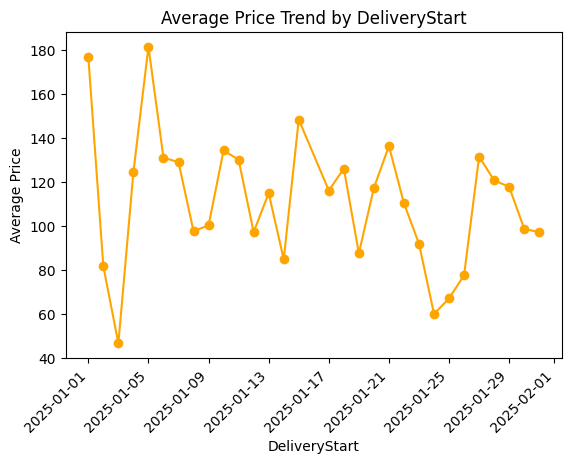

In [17]:
# 3. Line Chart – Notional Value Over Time
avg_price_trend = df.groupby("DeliveryStart")["Price"].mean().sort_index()
avg_price_trend.plot(kind="line", marker="o", color="orange")
plt.title("Average Price Trend by DeliveryStart")
plt.ylabel("Average Price")
plt.xlabel("DeliveryStart")
plt.xticks(rotation=45)
plt.show()


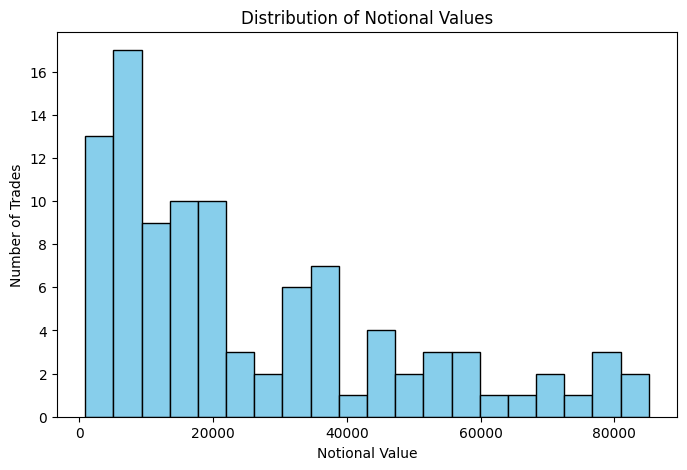

In [18]:
# 4. Histogram – Distribution of Notional values
df["Notional"]=df["Volume"]*df["Price"]
plt.figure(figsize=(8,5))
plt.hist(df["Notional"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Notional Values")
plt.xlabel("Notional Value")
plt.ylabel("Number of Trades")
plt.show()


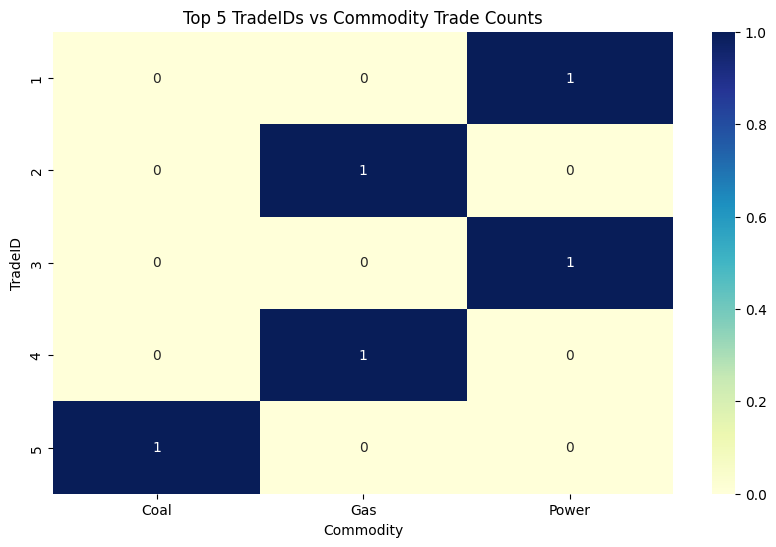

In [19]:

# Step 1: Pick top 5 TradeIDs by trade count
top_tradeids = df["TradeID"].value_counts().head(5).index

# Step 2: Filter dataset for only those top 5
df_top5 = df[df["TradeID"].isin(top_tradeids)]

# Step 3: Create heatmap (TradeID vs Commodity)
pivot_table = pd.crosstab(df_top5["TradeID"], df_top5["Commodity"])

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")

plt.title("Top 5 TradeIDs vs Commodity Trade Counts")
plt.xlabel("Commodity")
plt.ylabel("TradeID")
plt.show()
